In [7]:
## ============================== || BEGIN : DIR || ============================== ## 
from matplotlib.mathtext import List
Delphes_DIR = "/home/franky8939/PROGRAMAS/MG5_aMC_v2_6_7/Delphes/"
ROOT_DIR = "/home/franky8939/PROGRAMAS/root-6.18.02/"
inputFileROOT = "data/darkphoton_5GeV_ctau0.root"
## ============================== || END   : DIR || ============================== ## 
import sys
## ======================== || BEGIN : PATH IN PROYECT || ======================== ## 
""" 
This is necesary for import path for the bash because in the Jupyter of Pycharm 
not charge this bash include in the environment and is necessary por import the 
module of the program ROOT CERN 
"""
# not necesary for the moment
sys.path.extend([ Delphes_DIR ])  
sys.path.extend([ Delphes_DIR + "classes" ])
sys.path.extend([ Delphes_DIR + "external" ])
sys.path.extend([ Delphes_DIR + "external/ExRootAnalysis" ])
# necesary in the different configuration of installation of ROOT
sys.path.extend([ ROOT_DIR    + "lib" ])
sys.path.extend([ ROOT_DIR    + "root/lib" ])
sys.path.extend([ ROOT_DIR    + "build/lib" ])
## ======================== || END   : PATH IN PROYECT || ======================== ## 
import ROOT 
## ===================== || BEGIN : PYTHONPATH IN PROYECT || ===================== ## 
"""
This is necesary for import the path for the library of ROOT CERN and Delphes  
"""
ROOT.gInterpreter.AddIncludePath( Delphes_DIR )
ROOT.gInterpreter.AddIncludePath( Delphes_DIR + "classes" )
ROOT.gInterpreter.AddIncludePath( Delphes_DIR + "external/" )
ROOT.gInterpreter.AddIncludePath( Delphes_DIR + "external/ExRootAnalysis/" )
ROOT.gSystem.Load( Delphes_DIR + "libDelphes")

ROOT.gInterpreter.Declare('#include "DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "SortableObject.h"')
ROOT.gInterpreter.Declare('#include "ExRootTask.h"')
## ===================== || END   : PYTHONPATH IN PROYECT || ===================== ## 
## ============================ || BEGIN : MODULES || ============================ ## 
''' Modules using '''
import os
#import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import numpy as np
#import statistics as stats # usar media o desviacion estandar
import h5py as h # manipular extensiones
## ============================ || END   : MODULES || ============================ ## 

In [2]:
## ========================== || BEGIN : DEFINITION || =========================== ## 
class Config_Hist2D:
    """ Configure Histograms Graphic in 2D"""
    def __init__(self):
        self.grid = True 
        self.bins = 50 
        self.percentil = 0
        self.ylabel = " Frecuencia "
        self.start = True
    def __AddProp__(self, name, value = None):
        self.__dict__[name] = value

class DarkSUSY:
    def __init__(self):
        self._Registro_Name = "DarkSUSY Event Log"                  # type: str
        self._Registro_Dir  = "Log/"                                # type: str 
        self.File = None                                            # type: Delphes_Referencia
        self.Entries = -1                                           # type: int
        self.Mu_forEvent = np.array([])                             # type: List[float] > 0
#        self.MaxMuon = 4
        self.Mu_DiMu = np.array([])                                 # type: ndarray
        self.Mu_info = "LOG OF SELECCION OF TWO MUONS.txt"          # type: str
        self.Mu_info_log = bool(1)                                  # type: bool

        self.Config_Hist2D = Config_Hist2D()                        # type: object
        
    def _Add_File(self, name):
        """ 
        =========================================================================================================
        | Charge the file type XXX.root output of caracterization of Delphes                                    |
        =========================================================================================================
        | Examples:                                                                                             |
        | output = AddFile(input) or                                                                            | 
        | output = AddFile(input.root) or                                                                       |
        | output = AddFile(Data/input.root)                                                                     |
        =========================================================================================================
        | if the File  "(...).root" exist then "output" gets bool value 1, otherwise is 0                       |
        | The True case create the dependencies:                                                                |
        | self.Muon_N  :: Type = Vector[int]    :: This is one vector with the number of Muons in each entries  |
        | self.Entries :: Type = int            :: This is the number of event or entries for my data           |
        | self.File    :: Type = Title Delphes  :: Include the name of the Tree in the File Delphes             |
        =========================================================================================================  
        """
        output = bool(1)
        self.File = ROOT.TChain("Delphes;1")
        
        if isinstance(name,str) or isinstance(name + ".root",str): # existence of .root file
            if os.path.isfile(name) or os.path.isfile(name + ".root"):
                if  name[-5:]=='.root' :
                    self.File.Add(name)
                    print("The file " + name + ".root has been successfully loaded.")
                else:
                    self.File.Add(name + ".root")
                    print("The file " + name + " has been successfully loaded.")
            else:
                print("Error: The file " + name + " has not been successfully loaded, input dir is not exist.")
                output = 0
        else:
            print("Error: The file " + name + " has not been successfully loaded, input is not string.")
            output = 0
        # Variables needed to work
        self.Entries = self.File.GetEntries()   # Number of entrance
        self.Mu_forEvent = np.array([])         # Number of Muons for entrance
        
        for entry in range(self.Entries):
            self.File.GetEntry(entry)
            self.Mu_forEvent = np.append(self.Mu_forEvent, self.File.Muon.GetEntries())

        return output
    
    def Select_two_di_muon(self):
        
        f = open (self.Mu_info,'w') # CREATE TXT FILE TO SAVE THE CHARACTERIZATION PROCESS INFO
        output = []                                                 # type: 
        
        for entry in range(self.Entries):
            Event = self.File.GetEntry(entry)
            if  self.File.Muon.GetEntries()  > 3:
                Nmuon = self.File.Muon.GetEntries()
                Chargemuon = []
                f.write( "\n" + "||===========================================================================================================||")
                f.write( "\n" + "||                                 || SUMMARY OF EVENT CHARACTERIZATION ||                                   ||")
                f.write( "\n" + "||===========================================================================================================||")
                f.write( "\n" + "||                                   EVENT : "  + str(entry)  + " :: NUMBER OF MUONS : " + str(Nmuon) )
                
                for imuon in range(Nmuon):
                    Chargemuon.append(self.File.GetLeaf("Muon.Charge").GetValue( imuon ) )
                
                """ ===========================================================
                    || SELECT THE POSSIBLE DI-MUONES IN DEPENDENCE OF CHARGE ||
                    ===========================================================  """
                di_muon = []
                for one in range(len(Chargemuon)) :
                    for  two in range( one , len(Chargemuon) ) :
                        if  Chargemuon[one] + Chargemuon[two] == 0:
                            di_muon.append( [ one , two ] )

                """ ===========================================================
                             || ** SELECT THE PAIR WITH LOWER MASS ** ||
                    ===========================================================  """
                AllDiffInvMass = np.array([])        # type: float # 1D # Diff of Inv Mass
                AllInvMass     = np.array([])        # type: float # 2D # Values od Inv Mass
                Alltwo_di_muon = np.array([])        # type: float # 1D # All combination of Di-muon
                
                """" =================================
                     || COMBINATION OF TWO DI-MUONS ||
                     =================================  """
                for one in range( len(di_muon) ):
                    for two in range(one + 1, len(di_muon) ):
                        """" ============================
                             || Do not share particles ||
                             ============================  """
                        if di_muon[one][0] != di_muon[two][0] and di_muon[one][0] != di_muon[two][1]  and \
                                di_muon[one][1] != di_muon[two][0] and di_muon[one][1] != di_muon[two][1] :
                           
                            mass1 = ( self.File.Muon.At(di_muon[one][0]).P4() +
                                      self.File.Muon.At(di_muon[one][1]).P4() ).M() # First  Mass
                            mass2 = ( self.File.Muon.At(di_muon[two][0]).P4() +
                                      self.File.Muon.At(di_muon[two][1]).P4() ).M() # Second Mass
                            AllDiffInvMass = np.append( AllDiffInvMass , 
                                                        np.abs( mass1 - mass2 ) )  # [ (...) , |M1 - M2|]
                            # Indices di-muon1 (i,j) ; di-muon2 (n,m) -> [ i, j, n, m ]
                            two_di_muon = np.array([ di_muon[one][0] , di_muon[one][1] , 
                                                     di_muon[two][0] , di_muon[two][1] ])
                            if len(Alltwo_di_muon) == 0 :
                                Alltwo_di_muon = two_di_muon
                                AllInvMass     = [mass1 , mass2 ]
                            else:
                                Alltwo_di_muon = np.vstack( [ Alltwo_di_muon , two_di_muon      ] )
                                AllInvMass     = np.vstack( [ AllInvMass     , [mass1 , mass2 ] ] )
                
                f.write( "\n" + "||                                 =======================================                                   ||")  
                f.write( "\n" + "||                                 | All Couple of di-muones for select: |                                   ||")    
                f.write( "\n" + "||                                 =======================================                                   || ")  
                
                for count in range( len( AllInvMass ) ):
                    f.write("\n" + "||"+ " :: First di-muon: ["  + str(Alltwo_di_muon[count][0]) + " , " + str(Alltwo_di_muon[count][1]) + "] " + 
                          " with M1 : " + '%.2f' %AllInvMass[count][0] +
                          " :: Second di-muon: [" + str(Alltwo_di_muon[count][2]) + " , " + str(Alltwo_di_muon[count][3]) + "] " + 
                          " with M2 : " + '%.2f' %AllInvMass[count][1] + 
                          " :: \u0394 Minv : "  + '%.3f' %AllDiffInvMass[count])
                    
                f.write("\n" + "||                                 =======================================                                   ||")  
                f.write("\n" + "||                                 | The Couple of di-muones select is : |                                   ||")    
                f.write("\n" + "||                                 =======================================                                   ||")  
                
                # MIN OF MASS DIF IN THE VECTOR AllInvMAss
                logic = np.where(np.min(AllDiffInvMass) == AllDiffInvMass)[0][0] # MATRIX LOGIC
                #print(logic)
                DiMuon2 = (Alltwo_di_muon[logic]) # TWO DI-MUON WITH > (MASS1-MASS2)

                f.write("\n" + "||"+ " :: First di-muon: [" + str(DiMuon2[0]) + " , " + str(DiMuon2[1]) + "] " + 
                          " with M1 : " + '%.2f' %AllInvMass[logic][0] +
                          " :: Second di-muon: [" + str(DiMuon2[2]) + " , " + str(DiMuon2[3]) + "] " + 
                          " with M2 : " + '%.2f' %AllInvMass[logic][1])  #'''
                f.write( "\n" + "||===========================================================================================================||")
                
                ## ALL DI-MUON FOR EVENT
                if  len(output)==0:
                    output =np.hstack([entry,DiMuon2])
                else:
                    intg=np.hstack([ entry , DiMuon2])
                    output = np.vstack( [ output , intg] )
        f.close()
        ## RESUMEN FINAL
        '''print("De los ", self.Entries , " eventos procesados, ", sum(self.Nmuon>3) , " poseen mas de 3 muones y ",
              output.shape[0] , " fueron seleccionados bajo el criterio de minima masa invariante.")'''
        self.Mu_DiMu = output
        return output
    
    def fhist(self,selfnew, entrada):
    
        if selfnew.percentil>0 and selfnew.percentil<100 :
            log1 = np.percentile(entrada, selfnew.percentil)  < entrada 
            log2 = np.percentile(entrada, 100 - selfnew.percentil) > entrada
            log =log1*log2
            hist = []
            for i in range(len(entrada)):
                if log[i]:
                    hist.append(entrada[i])
        else:
            hist = entrada
            log = True
        ## GRAF
        
        if  hasattr(selfnew, "bins") : 
            if hasattr(selfnew, "xlim") :
                binss=int(round(selfnew.bins*(max(hist)- min(hist))/(selfnew.xlim[1]- selfnew.xlim[0])))
                #print(binss)
                plt.hist(np.delete(hist, log), bins= binss)
                print(1)
            else:
                plt.hist(np.delete(hist, log), bins= selfnew.bins)
                print(2)
        else:
            plt.hist(np.delete(hist, log), bins= 10)          
            print(3)
                
        ## PROP
        if    hasattr(selfnew, "xlim"): plt.xlim(selfnew.xlim[0],selfnew.xlim[1] )
        else: plt.xlim( min(hist), max(hist) )
        if    hasattr(selfnew, "ylim"): plt.ylim(selfnew.ylim[0],selfnew.ylim[1] )
        
        if    hasattr(selfnew, "title") and len(selfnew.title)>0: plt.title(selfnew.title)
        
        if    hasattr(selfnew, "grid"): plt.grid(selfnew.grid)
        else: plt.grid(True)
        
        if    hasattr(selfnew, "ylabel") and len(selfnew.ylabel)>0 : plt.ylabel(selfnew.ylabel)
        if    hasattr(selfnew, "xlabel") and len(selfnew.xlabel)>0 : plt.xlabel(selfnew.xlabel)
       
        if    selfnew.start: plt.show()
        else: print(" Auto plot is deactivate, change the bool .\"start\" ")
        plt.clf() # closed
        return 1
    
    def HistM(self):
        # MASA DE LOS DI-MUONES
        AllMass_of_photon = []
        AllminMass_of_photon = []
        AllmaxMass_of_photon = []
        ALL_DMuon_ForEvent = np.array(self.Mu_DiMu)
        for event_2dark in range( self.Mu_DiMu.shape[0] ) :#range( entries  ):
            Event = self.File.GetEntry(ALL_DMuon_ForEvent[ event_2dark,0 ])
            muones = self.File.Muon
            mass1 = ( muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 1] ) ).P4() + 
                      muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 2] ) ).P4() ).M()
            mass2 = ( muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 3] ) ).P4() + 
                      muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 4] ) ).P4() ).M()
            AllMass_of_photon.append(mass1)
            AllMass_of_photon.append(mass2)
            if mass1 > mass2:
                AllminMass_of_photon.append(mass2)
                AllmaxMass_of_photon.append(mass1)
            else:
                AllminMass_of_photon.append(mass1)
                AllmaxMass_of_photon.append(mass2)
                
        # Histogram of all mass
        self.Config_Hist2D.xlim = [np.percentile(AllMass_of_photon, 1), np.percentile(AllMass_of_photon, 99)]
        #plt.figure(1)
        plt.rcParams['figure.figsize'] = [10, 20]
        plt.subplot(311); 
        self.Config_Hist2D.title  = 'Mass of all DarkPhoton'
        self.Config_Hist2D.percentil = 2
        self.fhist(self.Config_Hist2D, AllMass_of_photon)
        
        plt.subplot(312); 
        self.title  = 'Mass of all Max-DarkPhoton'
        self.percentil = 0
        self.fhist(self.Config_Hist2D, AllmaxMass_of_photon)
        
        plt.subplot(313); 
        self.title  = 'Mass of all Min-DarkPhoton'
        self.percentil = 0
        self.fhist(self.Config_Hist2D, AllminMass_of_photon)
        
    def HistPt(self):
        AllPt_of_photon = []
        All1Pt_of_photon = []
        All2Pt_of_photon = []
        All3Pt_of_photon = []
        All4Pt_of_photon = []
        ALL_DMuon_ForEvent = np.array(self.Mu_DiMu)
        for event_2dark in range( self.Mu_DiMu.shape[0] ) :#range( entries  ):
            #print(event_2dark)
            Event = self.File.GetEntry(ALL_DMuon_ForEvent[ event_2dark,0 ])
            
            for imuon in range(4):
                AllPt_of_photon.append(self.File.GetLeaf("Muon.PT").GetValue( imuon ))
            AllPt_of_photon_event = np.hstack( [ AllPt_of_photon[-4:-1] , AllPt_of_photon[-1] ] )  
            AllPt_of_photon_event = np.sort(AllPt_of_photon_event)
            All1Pt_of_photon.append(AllPt_of_photon_event[0])
            All2Pt_of_photon.append(AllPt_of_photon_event[1])
            All3Pt_of_photon.append(AllPt_of_photon_event[2])
            All4Pt_of_photon.append(AllPt_of_photon_event[3])
            
        ## HISTOGRAMAS DE TODOS LOS MOMENTOS ANGULARES
        self.xlim = [ min(AllPt_of_photon_event), max(AllPt_of_photon_event)]
        #plt.figure(1)
        plt.rcParams['figure.figsize'] = [10, 20]
        plt.subplot(511); 
        self.title  = 'Momento Transversal de todos los Muones'
        self.fhist(self.Config_Hist2D, AllPt_of_photon)
        self.xlabel = " Momento Transversal"
        self.percentil = 0
        plt.subplot(512);
        self.title = "Momento Transversal de los Muones en la posicion 1"#'''
        self.fhist(self.Config_Hist2D, All1Pt_of_photon)
        plt.subplot(513);
        self.title = "Momento Transversal de los Muones en la posicion 2"#'''
        self.fhist(self.Config_Hist2D, All2Pt_of_photon)
        plt.subplot(514);
        self.title = "Momento Transversal de los Muones en la posicion 3"#'''
        self.fhist(self.Config_Hist2D, All3Pt_of_photon)
        plt.subplot(515);
        self.title = "Momento Transversal de los Muones en la posicion 4"#'''
        self.fhist(self.Config_Hist2D,All4Pt_of_photon)
        print(All4Pt_of_photon)

    '''#def _GeneraH5(self):
        
    #def GrafH5(self):
        name = darkphoton_5GeV_ctau0.h5
        # ENTRAR LA INFORMACION DESDE UN ARCHIVO EXTERNO
        FILE  = h.File(name, 'r')
        INPUT = np.vstack([FILE["qcd/images"][:], FILE["wprime/images"][:]]); INPUT=INPUT/np.max(INPUT) # SE NORMALIZA
        INPUT1 =FILE["qcd/images"][:] ;  INPUT2 =FILE["wprime/images"][:] ; 
        LABEL = np.hstack([FILE["qcd/labels"][:], FILE["wprime/labels"][:]])
        OUTPUT_LINEAL = np.ones((len(LABEL), 2));
        OUTPUT_LINEAL[:,0] = LABEL < 1    ;     OUTPUT_LINEAL[:,1] = LABEL > 0'''
        
        
        

In [3]:
DarkFile = DarkSUSY()
print(DarkFile._Add_File(inputFileROOT))
print(DarkFile.Select_two_di_muon())

The file darkphoton_5GeV_ctau0 has been successfully loaded.
True
[[  29    0    3    1    2]
 [  57    0    3    1    2]
 [  65    0    2    1    3]
 ...
 [9973    0    2    1    3]
 [9986    0    1    2    3]
 [9989    0    2    1    3]]


/home/franky8939/PROGRAMAS/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:190: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


1
1
1


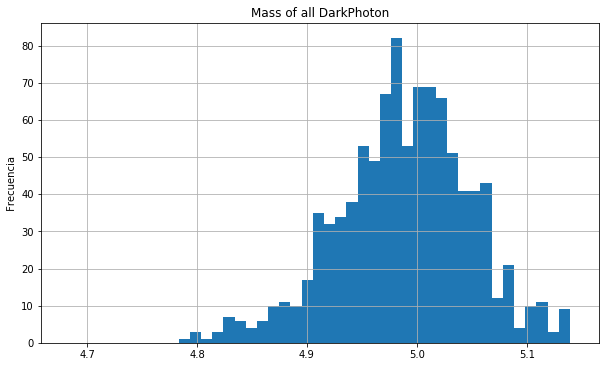

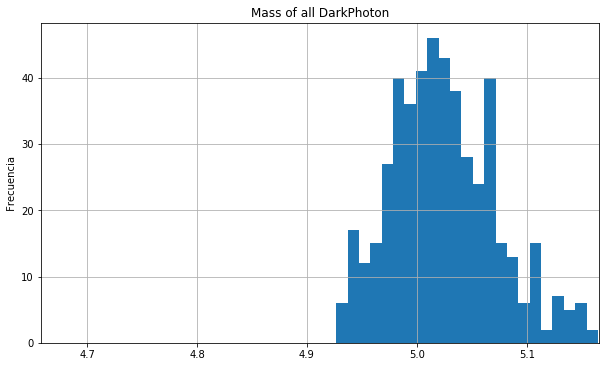

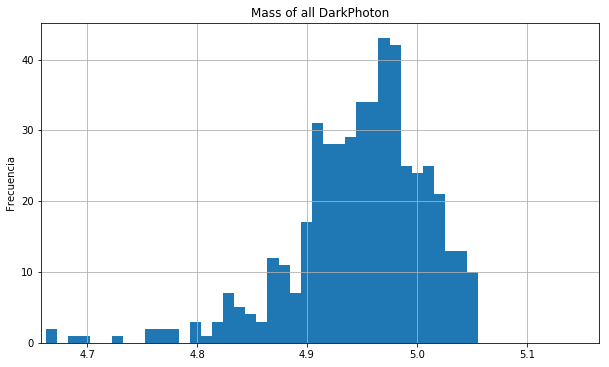

<Figure size 720x1440 with 0 Axes>

In [4]:
DarkFile.HistM()

/home/franky8939/PROGRAMAS/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:190: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


1
1
1
1
1
[105.60783386230469, 43.4626579284668, 40.9896125793457, 31.485267639160156, 34.93770217895508, 53.10191345214844, 28.08157730102539, 41.95874786376953, 42.62446594238281, 78.76454162597656, 35.83771896362305, 32.13993835449219, 88.35940551757812, 42.61649703979492, 32.362056732177734, 25.31676483154297, 30.259628295898438, 36.31843566894531, 73.02870178222656, 19.66555404663086, 34.467647552490234, 137.12669372558594, 17.705167770385742, 33.321205139160156, 40.25178909301758, 37.401756286621094, 32.872684478759766, 47.012935638427734, 46.41507339477539, 21.543180465698242, 43.413455963134766, 35.90403747558594, 33.23059844970703, 46.79899597167969, 31.813295364379883, 34.688682556152344, 30.068918228149414, 30.1109676361084, 40.77542495727539, 92.59391784667969, 31.54745864868164, 37.38408279418945, 18.19864273071289, 31.022064208984375, 129.62289428710938, 53.437007904052734, 34.133426666259766, 100.86268615722656, 22.08159065246582, 40.66505432128906, 142.91677856445312, 8

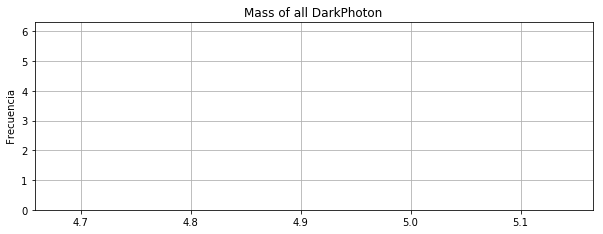

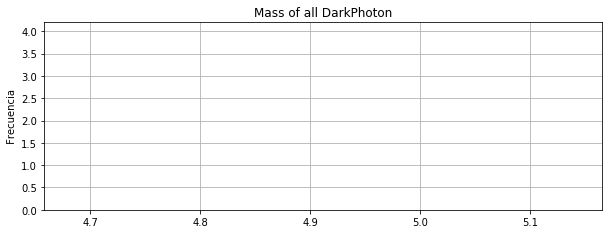

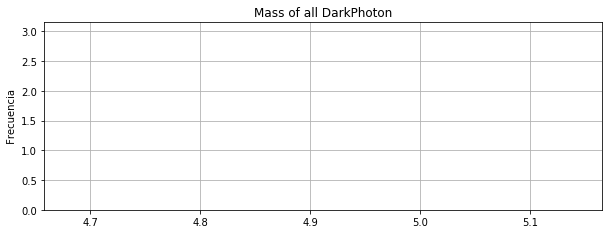

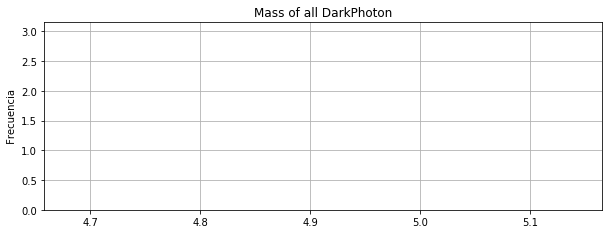

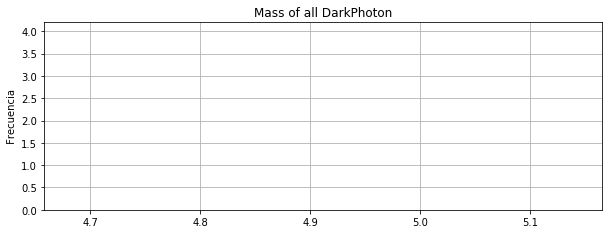

<Figure size 720x1440 with 0 Axes>

In [5]:
DarkFile.HistPt()

In [6]:
DarkFile.Config_Hist2D.xlim
DarkFile.Config_Hist2D.bins

SyntaxError: invalid syntax (<ipython-input-6-29cf44665fd8>, line 1)

In [11]:
name = "data/darkphoton_5GeV_ctau0.h5"
# ENTRAR LA INFORMACION DESDE UN ARCHIVO EXTERNO
FILE  = h.File(name, 'r')
print(FILE.attrs.keys())

[]


In [ ]:
INPUT = np.vstack([FILE["qcd/images"][:], FILE["wprime/images"][:]]); INPUT=INPUT/np.max(INPUT) # SE NORMALIZA
INPUT1 =FILE["qcd/images"][:] ;  INPUT2 =FILE["wprime/images"][:] ; 
LABEL = np.hstack([FILE["qcd/labels"][:], FILE["wprime/labels"][:]])
OUTPUT_LINEAL = np.ones((len(LABEL), 2));
OUTPUT_LINEAL[:,0] = LABEL < 1    ;     OUTPUT_LINEAL[:,1] = LABEL > 0'''
